In [ ]:
# 필요한 라이브러리 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from collections import Counter
from IPython.core.display import display, HTML
sns.set_style('darkgrid')

C:\Users\82107\AppData\Local\Temp\ipykernel_9452\3981848155.py:9: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [ ]:
log_data = pd.read_csv(r"C:\Users\82107\Desktop\Uni\2022-2R\KUBIG project\log_data.csv")
loan_result = pd.read_csv(r"C:\Users\82107\Desktop\Uni\2022-2R\KUBIG project\loan_result.csv")
user_spec = pd.read_csv(r"C:\Users\82107\Desktop\Uni\2022-2R\KUBIG project\user_spec.csv")

In [ ]:


#유저 스펙에서 user_id와 application_id를 뭉치면 값이 모두 고유함...!
user_spec.duplicated(['user_id','application_id']).sum()

user_spec.duplicated(['application_id']).sum()

#최종 제출 데이터셋에서 product_id와 application_id가 키가 되므로 겹치는 건 제거해도  
loan_result.duplicated(['product_id','application_id']).sum()

#중복 데이터 제거
loan_result = loan_result.drop_duplicates()
user_spec = user_spec.drop_duplicates()
log_data = log_data.drop_duplicates()

#대출신청 데이터가 NaN이 아니면 train, 
#이에 해당하는 대출신청서(application_id), 사용자(user_id)가 있는 세트를 추출
train_loan = loan_result[loan_result['is_applied'].notnull()]
train_user = user_spec.loc[user_spec['application_id'].isin(train_loan['application_id'])]
train_log = log_data.loc[log_data['user_id'].isin(train_user['user_id'])]

#대출신청 데이터가 NaN이면 test, 
#이에 해당하는 대출신청서(application_id), 사용자(user_id)가 있는 세트를 추출
test_loan = loan_result[loan_result['is_applied'].isna()]
test_user = user_spec.loc[user_spec['application_id'].isin(test_loan['application_id'])]
test_log = log_data.loc[log_data['user_id'].isin(test_user['user_id'])]

#loan_result를 기준으로 user_spec과 병합
test_loan = pd.merge(test_loan, test_user, on='application_id', how='left')
train_loan = pd.merge(train_loan, train_user, on='application_id', how='left')

test_loan = test_loan.drop_duplicates(['application_id','product_id'])

train_loan = train_loan.drop_duplicates(['application_id','product_id'])

#데이터프레임 크기 상황
print(loan_result.shape, user_spec.shape, log_data.shape)
print(test_loan.shape, test_user.shape, test_log.shape)
print(train_loan.shape, train_user.shape, train_log.shape)

(13527337, 7) (1394216, 17) (17359850, 6)
(3257034, 23) (239949, 17) (7332541, 6)
(10269424, 23) (728884, 17) (12761541, 6)


In [ ]:
####4-1.결측치 파악 & 트레인 결측행 제거

#결측치가 하나라도 있는 행을 리스트로 기록
test_na = test_loan.columns[test_loan.isnull().sum() > 0].values
train_na = train_loan.columns[train_loan.isnull().sum() > 0].values

#결측치 유형 체크
na_train = list(set(train_na) - set(test_na))
na_test = list(set(train_na) - (set(train_na) - set(test_na)))

print("train에서만 결측(결측 인덱스 삭제 가능):\n", na_train)
print("양쪽 다 결측(인덱스 삭제 불가, 대치하거나 column 삭제하거나):\n", na_test)

#트레인에만 있는 결측치 비율
pd.options.display.float_format = '{:.6f}'.format
train_loan[na_train].isnull().sum()/len(train_loan)

#둘 다 있는 결측치 비율(트레인)
train_loan[na_test].isnull().sum()/len(train_loan)

train_loan1 = train_loan.dropna(subset=na_train)

#둘 다 있는 결측치 비율(테스트)
test_loan[na_test].isnull().sum()/len(test_loan)

#트레인에만 있는 결측치 제거 후 트레인 셋 변화, 크지 않으므로 그대로 진행
train_loan1 = train_loan.dropna(subset=na_train)
train_loan1 = train_loan1.dropna(subset=['loan_rate', 'loan_limit'])
test_loan = test_loan.dropna(subset=['loan_rate', 'loan_limit'])
print(train_loan.shape, train_loan1.shape, test_loan.shape)

train에서만 결측(결측 인덱스 삭제 가능):
 ['income_type', 'employment_type', 'desired_amount', 'insert_time', 'purpose', 'user_id', 'houseown_type']
양쪽 다 결측(인덱스 삭제 불가, 대치하거나 column 삭제하거나):
 ['personal_rehabilitation_yn', 'loan_limit', 'loan_rate', 'gender', 'birth_year', 'company_enter_month', 'credit_score', 'personal_rehabilitation_complete_yn', 'existing_loan_amt', 'existing_loan_cnt', 'yearly_income']
(10269424, 23) (10263894, 23) (3255302, 23)


In [ ]:
####4-2 개인회생 변수에 '무응답' 추가 -> 완료, 미완료 더미변수화

#personal_rehabilitation 시리즈는 yes(1) or no(0)이기 때문에 범주형으로 변환, 결측치는 무응답(none)으로 대치
train_loan2 = train_loan1.replace({'personal_rehabilitation_yn': 0}, {'personal_rehabilitation_yn': 'no'})
train_loan2 = train_loan2.replace({'personal_rehabilitation_yn': 1}, {'personal_rehabilitation_yn': 'yes'})
train_loan2 = train_loan2.replace({'personal_rehabilitation_yn': np.nan}, {'personal_rehabilitation_yn': 'none'})
train_loan2 = train_loan2.replace({'personal_rehabilitation_complete_yn': 0}, {'personal_rehabilitation_complete_yn': 'no'})
train_loan2 = train_loan2.replace({'personal_rehabilitation_complete_yn': 1}, {'personal_rehabilitation_complete_yn': 'yes'})
train_loan2 = train_loan2.replace({'personal_rehabilitation_complete_yn': np.nan}, {'personal_rehabilitation_complete_yn': 'none'})

#테스트 셋에도...
test_loan1 = test_loan.replace({'personal_rehabilitation_yn': 0}, {'personal_rehabilitation_yn': 'no'})
test_loan1 = test_loan1.replace({'personal_rehabilitation_yn': 1}, {'personal_rehabilitation_yn': 'yes'})
test_loan1 = test_loan1.replace({'personal_rehabilitation_yn': np.nan}, {'personal_rehabilitation_yn': 'none'})
test_loan1 = test_loan1.replace({'personal_rehabilitation_complete_yn': 0}, {'personal_rehabilitation_complete_yn': 'no'})
test_loan1 = test_loan1.replace({'personal_rehabilitation_complete_yn': 1}, {'personal_rehabilitation_complete_yn': 'yes'})
test_loan1 = test_loan1.replace({'personal_rehabilitation_complete_yn': np.nan}, {'personal_rehabilitation_complete_yn': 'none'})

train_loan2['rehabilitation_complete'] = np.where(train_loan2['personal_rehabilitation_complete_yn']=='yes', 1, 0)
train_loan2['rehabilitation_incomplete'] = np.where(train_loan2['personal_rehabilitation_complete_yn']=='no', 1, 0)

train_loan2 = train_loan2.drop(columns = ['personal_rehabilitation_yn','personal_rehabilitation_complete_yn'])


test_loan1['rehabilitation_complete'] = np.where(test_loan1['personal_rehabilitation_complete_yn']=='yes', 1, 0)
test_loan1['rehabilitation_incomplete'] = np.where(test_loan1['personal_rehabilitation_complete_yn']=='no', 1, 0)

test_loan1 = test_loan1.drop(columns = ['personal_rehabilitation_yn','personal_rehabilitation_complete_yn'])

train_loan2[['rehabilitation_complete','rehabilitation_incomplete']].value_counts()

test_loan1[['rehabilitation_complete','rehabilitation_incomplete']].value_counts()

rehabilitation_complete  rehabilitation_incomplete
0                        0                            2560141
                         1                             692628
1                        0                               2533
dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
label=list(train_loan2.select_dtypes(include = 'object').columns)
oneset=[train_loan2, test_loan1]

for data in oneset:
  for i in label:
    data[i] = encoder.fit_transform(np.array(data[i]))

test_loan1[label].head()

,loanapply_insert_time,insert_time,income_type,employment_type,houseown_type,purpose
0,146652,38913,0,3,2,1
1,146652,38913,0,3,2,1
2,146652,38913,0,3,2,1
3,146652,38913,0,3,2,1
4,146652,38913,0,3,2,1


In [ ]:
test_loan1['yearly_income']=test_loan1['yearly_income'].fillna((train_loan2['yearly_income'].median()))

In [ ]:
def get_missings(df):
    labels,values = list(),list()
    for column in df.columns:
           if df[column].isnull().sum():
            labels.append(column)
            values.append((df[column].isnull().sum() / len(df[column]))*100)
            missings=pd.DataFrame({'Column':labels,
                                   'Missing(Percent)':values}).sort_values(by='Missing(Percent)',
                                                                           ascending=False)
    return missings

In [ ]:
features_with_Nan = get_missings(train_loan2).Column.to_list()

# Number of features containing Nan values
print('There are ',len(features_with_Nan), 'features with Nan values')
print('The missing features are',features_with_Nan)

There are  6 features with Nan values
The missing features are ['existing_loan_amt', 'existing_loan_cnt', 'credit_score', 'company_enter_month', 'birth_year', 'gender']


In [ ]:
imp_need_col_test_num=test_loan1.loc[:,["birth_year","credit_score","existing_loan_cnt", "existing_loan_amt"]]
imp_need_col_train_num=train_loan2.loc[:,["birth_year","credit_score","existing_loan_cnt", "existing_loan_amt"]]
imp_need_col_test_cat=test_loan1.loc[:,["gender","company_enter_month"]]
imp_need_col_train_cat=train_loan2.loc[:,["gender","company_enter_month"]]

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(imp_need_col_train_num)
IterativeImputer(random_state=0)
imp_need_col_test_num1=np.round(imp.fit_transform(imp_need_col_test_num))
imp_need_col_train_num1= np.round(imp.fit_transform(imp_need_col_train_num))

In [ ]:
missing_columns = ["birth_year","credit_score","existing_loan_cnt", "existing_loan_amt"]

In [ ]:
imputed_train=pd.DataFrame(imp_need_col_train_num1,columns=missing_columns)
imputed_test=pd.DataFrame(imp_need_col_test_num1,columns=imp_need_col_test_num.columns)

In [ ]:
missing_cat = list(imp_need_col_train_cat.columns)
for i in missing_cat:
    imp_need_col_train_cat[i] = imp_need_col_train_cat[i].fillna(imp_need_col_train_cat[i].mode()[0])
    imp_need_col_test_cat[i] = imp_need_col_test_cat[i].fillna(imp_need_col_train_cat[i].mode()[0])

In [ ]:
print(imputed_train.shape)
print(imp_need_col_train_cat.shape)

(10263894, 4)
(10263894, 2)


In [ ]:
imputed_train.reset_index(drop=True, inplace=True)
imp_need_col_train_cat.reset_index(drop=True, inplace=True)
imputed_test.reset_index(drop=True, inplace=True)
imp_need_col_test_cat.reset_index(drop=True, inplace=True)

In [ ]:
imputedtrain = pd.concat([imp_need_col_train_cat,imputed_train], axis=1)
imputedtest = pd.concat([imp_need_col_test_cat,imputed_test], axis=1)

In [ ]:
imputedtrain1 = pd.DataFrame(imputedtrain, columns=imputedtrain.columns)
imputedtest1 = pd.DataFrame(imputedtest, columns=imputedtest.columns)

In [ ]:
train1=train_loan2.drop(['gender', 'company_enter_month', 'birth_year', 'credit_score','existing_loan_cnt', 'existing_loan_amt'], axis=1)
test1=test_loan1.drop(['gender', 'company_enter_month', 'birth_year', 'credit_score','existing_loan_cnt', 'existing_loan_amt'], axis=1)

In [ ]:
train1.reset_index(drop=True, inplace=True)
test1.reset_index(drop=True, inplace=True)

In [ ]:
train2=pd.concat([train1, imputedtrain1], axis=1)
test2=pd.concat([test1, imputedtest1], axis=1)

In [ ]:
test2.isna().sum()

application_id                     0
loanapply_insert_time              0
bank_id                            0
product_id                         0
loan_limit                         0
loan_rate                          0
is_applied                   3255302
user_id                            0
insert_time                        0
yearly_income                      0
income_type                        0
employment_type                    0
houseown_type                      0
desired_amount                     0
purpose                            0
rehabilitation_complete            0
rehabilitation_incomplete          0
gender                             0
company_enter_month                0
birth_year                         0
credit_score                       0
existing_loan_cnt                  0
existing_loan_amt                  0
dtype: int64

In [ ]:
transform_column=['loan_limit','yearly_income','desired_amount','existing_loan_cnt','existing_loan_amt']

In [ ]:
train2['loan_limit'] = train2['loan_limit'].clip(lower = 0.00001)
train2['yearly_income'] = train2['yearly_income'].clip(lower = 0.00001)
train2['desired_amount'] = train2['desired_amount'].clip(lower = 0.00001)
train2['existing_loan_cnt'] = train2['existing_loan_cnt'].clip(lower = 0.00001)
train2['existing_loan_amt'] = train2['existing_loan_amt'].clip(lower = 0.00001)

In [ ]:
test2['loan_limit'] = test2['loan_limit'].clip(lower = 0.00001)
test2['yearly_income'] = test2['yearly_income'].clip(lower = 0.00001)
test2['desired_amount'] = test2['desired_amount'].clip(lower = 0.00001)
test2['existing_loan_cnt'] = test2['existing_loan_cnt'].clip(lower = 0.00001)
test2['existing_loan_amt'] = test2['existing_loan_amt'].clip(lower = 0.00001)

In [ ]:
from scipy import stats

In [ ]:
fitted_data_1_train, fitted_lambda_1_train = stats.boxcox(train2['loan_limit'])
fitted_data_2_train, fitted_lambda_2_train = stats.boxcox(train2['yearly_income'])
fitted_data_3_train, fitted_lambda_3_train = stats.boxcox(train2['desired_amount'])
fitted_data_4_train, fitted_lambda_4_train = stats.boxcox(train2['existing_loan_cnt'])
fitted_data_5_train, fitted_lambda_5_train = stats.boxcox(train2['existing_loan_amt'])


In [ ]:
print(f"Lambda value used for Transformation: {fitted_lambda_1_train}")
print(f"Lambda value used for Transformation: {fitted_lambda_2_train}")
print(f"Lambda value used for Transformation: {fitted_lambda_3_train}")
print(f"Lambda value used for Transformation: {fitted_lambda_4_train}")
print(f"Lambda value used for Transformation: {fitted_lambda_5_train}")

Lambda value used for Transformation: 0.27900191848685163
Lambda value used for Transformation: 0.23015083451814475
Lambda value used for Transformation: 0.133600581698523
Lambda value used for Transformation: 0.018613033494703998
Lambda value used for Transformation: 0.27287566906353156


In [ ]:
import math
def box_cox(x,lmbda):
    return[(math.pow(v,lmbda)-1)/lmbda for v in x]

In [ ]:
test_loan1=test2
test_loan1["loan_limit"]=box_cox(test2["loan_limit"],0.27900191848685163)

In [ ]:
test_loan1["yearly_income"]=box_cox(test2["yearly_income"],0.23015083451814475)

In [ ]:
test_loan1["desired_amount"] = box_cox(test2["desired_amount"],0.133600581698523)

In [ ]:
test_loan1["existing_loan_cnt"] = box_cox(test2["existing_loan_cnt"],0.018613033494703998)

In [ ]:
test_loan1["existing_loan_amt"] = box_cox(test2["existing_loan_amt"],0.27287566906353156)

C:\Users\82107\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\82107\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\82107\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdep

<AxesSubplot:ylabel='Density'>

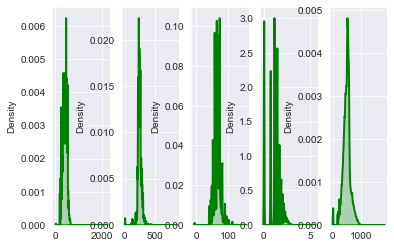

In [ ]:
fig, ax = plt.subplots(1, 5)
 
sns.distplot(fitted_data_1_train, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "Non-Normal", color ="green", ax = ax[0])

sns.distplot(fitted_data_2_train, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "Non-Normal", color ="green", ax = ax[1])

sns.distplot(fitted_data_3_train, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "Non-Normal", color ="green", ax = ax[2])

sns.distplot(fitted_data_4_train, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "Non-Normal", color ="green", ax = ax[3])

sns.distplot(fitted_data_5_train, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "Non-Normal", color ="green", ax = ax[4])

In [ ]:
transformed_train=pd.DataFrame(np.transpose([fitted_data_1_train,fitted_data_2_train,fitted_data_3_train,fitted_data_4_train,fitted_data_5_train]),
                              columns = ['loan_limit','yearly_income','desired_amount','existing_loan_cnt','existing_loan_amt'])

In [ ]:
train2.drop(['loan_limit','yearly_income','desired_amount','existing_loan_cnt','existing_loan_amt'], axis=1)
train3=pd.concat([transformed_train,train2], axis=1)


In [ ]:
train_loan2=train3

In [ ]:
###5.로그데이터 병합

train_user = train_loan2[['user_id']]
test_user = test_loan1[['user_id']]

log_data[['event']].value_counts()

for i in list(log_data['event'].unique()):
  print(i)
  log_limit = log_data[log_data['event']==i]
  log_limit = log_limit[['user_id']]
  log_limit[i] = 1
  log_limit = log_limit.drop_duplicates(ignore_index = True)
  log_limit = log_limit.drop(log_limit[~log_limit['user_id'].isin(train_user['user_id'])].index)
  print(log_limit.shape)
  train_user = train_user.merge(log_limit, on='user_id', how='left')
  train_user = train_user.fillna(0)
  train_loan2[i] = train_user[i]
  train_user = train_loan2[['user_id']]

cor3 = train_loan2[list(log_data['event'].unique())].corrwith(other = train_loan2['is_applied'])
cor3 = cor3.reset_index()
cor3.sort_values(0, ascending=False)

cor4 = train_loan2[list(log_data['event'].unique())].corr()
cor4 = cor4.reset_index()
cor4.sort_values('EndLoanApply', ascending=True)

Use = ['EndLoanApply', 'UseLoanManage']
Not_Use = list(set(log_data['event'].unique()) - set(Use)) 
train_loan6 = train_loan2.drop(Not_Use, axis=1)
train_loan6.info()

for i in Use:
  print(i)
  test_user = test_loan1[['user_id']]
  log_limit = log_data[log_data['event']==i]
  log_limit = log_limit[['user_id']]
  log_limit[i] = 1
  log_limit = log_limit.drop_duplicates(ignore_index = True)
  log_limit = log_limit.drop(log_limit[~log_limit['user_id'].isin(train_user['user_id'])].index)
  print(log_limit.shape)
  test_user = test_user.merge(log_limit, on='user_id', how='left')
  test_user = test_user.fillna(0)
  test_loan1[i] = test_user[i]


StartLoanApply
(205694, 2)
ViewLoanApplyIntro
(208407, 2)
EndLoanApply
(211758, 2)
OpenApp
(199218, 2)
UseLoanManage
(159545, 2)
UsePrepayCalc
(3098, 2)
Login
(169612, 2)
CompleteIDCertification
(203151, 2)
UseDSRCalc
(2373, 2)
SignUp
(12463, 2)
GetCreditInfo
(205325, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10263894 entries, 0 to 10263893
Data columns (total 30 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   loan_limit                 float64
 1   yearly_income              float64
 2   desired_amount             float64
 3   existing_loan_cnt          float64
 4   existing_loan_amt          float64
 5   application_id             int64  
 6   loanapply_insert_time      int32  
 7   bank_id                    int64  
 8   product_id                 int64  
 9   loan_limit                 float64
 10  loan_rate                  float64
 11  is_applied                 float64
 12  user_id                    float64
 13  insert_t

In [ ]:
test_loan1.columns

Index(['application_id', 'loanapply_insert_time', 'bank_id', 'product_id',
       'loan_limit', 'loan_rate', 'is_applied', 'user_id', 'insert_time',
       'yearly_income', 'income_type', 'employment_type', 'houseown_type',
       'desired_amount', 'purpose', 'rehabilitation_complete',
       'rehabilitation_incomplete', 'gender', 'company_enter_month',
       'birth_year', 'credit_score', 'existing_loan_cnt', 'existing_loan_amt',
       'EndLoanApply', 'UseLoanManage'],
      dtype='object')

In [ ]:
address = "C:\\Users\\82107\\Desktop\\Uni\\2022-2R\\KUBIG project\\"

In [ ]:
train_loan6.to_csv(address+"train.csv")
test_loan1.to_csv(address+"test.csv")